In [940]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
import os
from skimage.transform import pyramid_gaussian

Cilj ovog zadatka je procena kretanja na slikama odnosno estimacija optičkog toka. Za ovo ćemo koristiti **Lucas-Kanade** algoritam. Procenu optičkog toka nećemo vršiti nad svim tačkama već samo na obeležijima dobijenim iz funkcije *goodFeaturesToTrack* iz *OpenCV* biblioteke specijalno napravljenom za izdvajanje obeležja za estimaciju optičkog toka. Obeležja se detektuju na prvoj slici i zatim se prate tako što se na lokaciju obeležja dodaje procenjeni pomeraj i to predstavlja poziciju obeležja na narednoj slici. Takođe, potrebna je odbaciti nevalidna obeležja odnosno obeležja za koja nije dobro procenjen pomeraj te na narednoj slici ne opisuju istu tačku. Validnost obeležja se proverava tako što se srednja kvadratna greška vrednosti piksela iz prozora 3x3 oko obeležja na jednoj odnosno drugoj slici. Pre računanja srednje kvadratne greške ovi prozori su normalizovani oduzimanjem srednje vrednosti i deljenjem sa standardnom devijacijom kako bi bili robusni na promenu osvetljaja. Lukas-Kanade algoritma se zasniva na jednačini optičkog toka koja se izvodi pod pretpostavkom malih pomeraja (manji od 1 piksela) i konstantnog osvetljaja i glasi $I_t + I_xu + I_yv = 0$, gde $u$ i $v$ predstavljaju pomeraj koji želimo da estimiramo, a ostali članovi izvode po x,y odnosno vremenskoj koordinati. Nažalost, ovaj sistem je neodređen odnosno daje beskonačno mnogo rešenja. Kako bismo ovo rešili posmatraju se tačke u prozoru 5x5 oko obeležja. Za Lukas-Kanade algoritam je specifično da pretpostavlja da susedne tačke imaju isti pomeraj što je veoma razumna pretpostavka za rigidne objekte. Kako zbog šuma najverovatnije neće postojati rešenje koje zadovoljava ceo sistem za rešenje se uzima onaj pomeraj koji minimizuje srednju kvadratnu grešku odnosno vektor pomeraja se računa pseudo-inverzijom kao $x = (A^TA)^{-1}A^Tb$, gde prva kolona matrice $A$ predstavlja vrednosti gradijenta po x-osi za svaku tačku iz prozora, druga kolona predstavlja gradijent po y-osi, a matrice $b$ je negativni vremenski gradijent. Ispod je data implementacija ovog algoritma.

In [941]:
def lucasKanade(img1,img2,keypoints,winSize,errThr):
    
    height,width = img1.shape
    
    N = keypoints.shape[0]
    
    It = img2 - img1
    Ix = cv.Sobel(img1,cv.CV_64F,1,0)
    Iy = cv.Sobel(img1,cv.CV_64F,0,1)

    
    flowVectors = np.zeros((N,2))
    
    for k,point in enumerate(keypoints):
        
        i,j = point
        A = []
        b = []
        for m in range(i-winSize//2,i+winSize//2+1):
            for n in range(j - winSize//2,j+winSize//2+1):
                A.append([Ix[m,n],Iy[m,n]])
                b.append([-It[m,n]])
                
        A = np.array(A)
        b = np.array(b)
        
        x = np.linalg.inv(np.transpose(A)@A)@np.transpose(A)@b
        
        flowVectors[k,:] = x.reshape(-1)
        
    
    validPoints = np.zeros(N,dtype='bool')
    
    for k, point in enumerate(keypoints):
        size = 3
        i,j = point
        
        new_i = i + flowVectors[k][1]
        new_j = j + flowVectors[k][0]

        
        if (0 <= new_i < height) and (0 <= new_j < width):
            
            win1 = img1[i-size//2:i+size//2+1,j-size//2:j+size//2+1]
            
            # Zbog problema zaokruzivanja koristimo bilinearnu interpolaciju
            win2 = img2[int(np.round(new_i))-1:int(np.round(new_i))+2,
                        int(np.round(new_j))-1:int(np.round(new_j))+2]*\
                        (1-(new_j-int(new_j)))*(1-(new_i-int(new_i)))+\
                    img2[int(np.round(new_i))-1+1:int(np.round(new_i))+2+1,
                         int(np.round(new_j))-1:int(np.round(new_j))+2]*\
                         (1-(new_j-int(new_j)))*(new_i-int(new_i))+\
                    img2[int(np.round(new_i))-1:int(np.round(new_i))+2,
                         int(np.round(new_j))-1+1:int(np.round(new_j))+2+1]*\
                         (new_j-int(new_j))*(1-(new_i-int(new_i)))+\
                    img2[int(np.round(new_i))-1+1:int(np.round(new_i))+2+1,
                         int(np.round(new_j))-1+1:int(np.round(new_j))+2+1]*\
                         (new_j-int(new_j))*(new_i-int(new_i))
            
            # Normalizacija (izbeljivanje)
            m1 = np.mean(win1)
            m2 = np.mean(win2)
            
            std1 = np.std(win1)
            std2 = np.std(win2)
            
            win1 = (win1 - m1)/std1
            win2 = (win2 - m2)/std2
            
            if np.mean((win1 - win2)**2) < errThr:
                
                validPoints[k] = True
        
        
    
    return flowVectors, validPoints

Ispod su prikazana pronađena obeležja na prvoj slici u sekvenci pomoću funkcije *goodFeaturesToTrack*. Parametri ove funkcije su ulazna slika, maksimalan broj obeležja koje želimo da pronađemo (ako ih ima više uzimaju se najkvalitetnija), minimalan kvalitet obeležja i minimalna distanca između dva obeležja. Kvalitet obeležja predstavlja manja sopstvena vrednost to jest što je ona veća to je obeležje kvalitetnije. Za maksimalni broj obeležja je uzeto 200, za minimalan kvalitet 0.1, a za minimalno prostorno rastojanje 10 piksela. Pre detekcije slike su prebačene u *grayscale* i normalizovane na interval od 0 do 1.

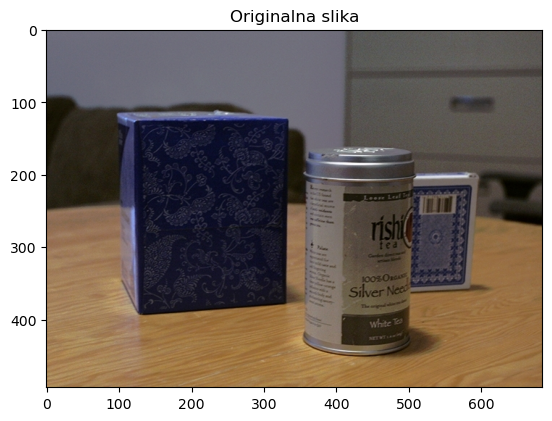

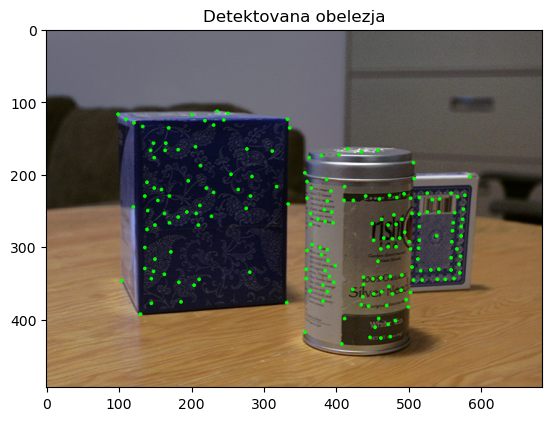

In [942]:
img_color = cv.imread("Can/frame01.jpg")
img_color = cv.cvtColor(img_color,cv.COLOR_BGR2RGB)

img = cv.imread("Can/frame01.jpg", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("Can/frame02.jpg", cv.IMREAD_GRAYSCALE)

img = (img - np.min(img))/(np.max(img)-np.min(img))
img2 = (img2 - np.min(img2))/(np.max(img2)-np.min(img2))

img = img.astype(np.float32)
img2 = img2.astype(np.float32)

plt.imshow(img_color)
plt.title("Originalna slika")
plt.show()

keypoints = cv.goodFeaturesToTrack(img,200,0.1,10)
keypoints = np.int64(keypoints.reshape((len(keypoints),2)))

tmp = keypoints[:,0].copy()
keypoints[:,0] = keypoints[:,1]
keypoints[:,1] = tmp

for point in keypoints:
    cv.circle(img_color,[point[1],point[0]],1,(0,255,0),2)
    

plt.imshow(img_color)
plt.title("Detektovana obelezja")
plt.show()

Primenom algoritma na prve dve slike u sekvenci dobijeni su vektori pomeraja i prikazani na slici (zelene strelice predstavljaju tačke koje su ostale validne, dok crvene predstavljaju odbačene tačke). Možemo primetiti da je za male pomeraje algoritam odradio solidan posao (kutija sa kartama) i da je tu većina tačaka ostala validna. Na velikoj kutiji i konzervi je situacija dosta lošija. Za granicu greške uzeto je 2.

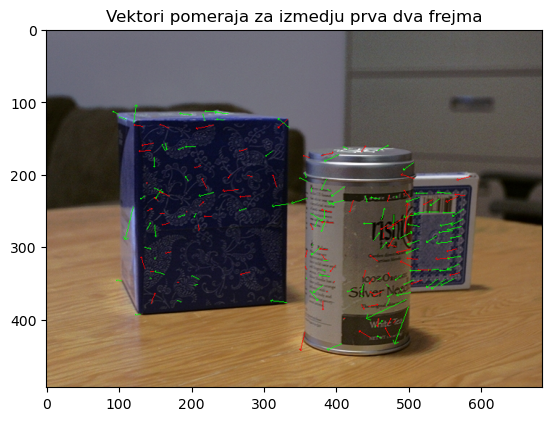

In [943]:
flowVectors, validPoints = lucasKanade(img,img2,keypoints,5,2)

img_color = cv.imread("Can/frame01.jpg")
img_color = cv.cvtColor(img_color,cv.COLOR_BGR2RGB)

for i in range(len(keypoints)):
    l = 100*math.sqrt(flowVectors[i][0]**2 + flowVectors[i][1]**2)
    angle = math.atan2(flowVectors[i][0],flowVectors[i][1])
    
    if validPoints[i]:
        cv.arrowedLine(img_color,[keypoints[i][1],keypoints[i][0]],[int(keypoints[i][1] + l*math.sin(angle)),int(keypoints[i][0] + l*math.cos(angle))],(0,255,0),1)
    else:
        cv.arrowedLine(img_color,[keypoints[i][1],keypoints[i][0]],[int(keypoints[i][1] + l*math.sin(angle)),int(keypoints[i][0] + l*math.cos(angle))],(255,0,0),1)

plt.imshow(img_color)
plt.title("Vektori pomeraja za izmedju prva dva frejma")
plt.show()

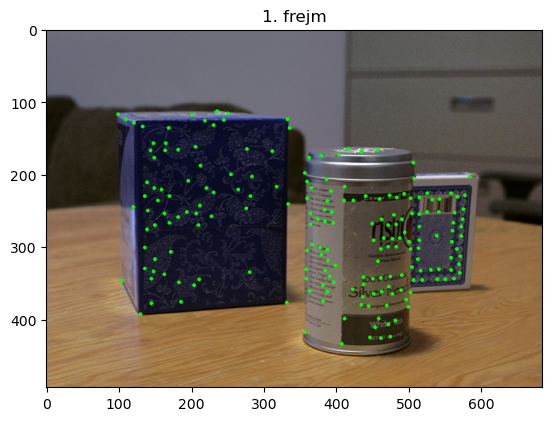

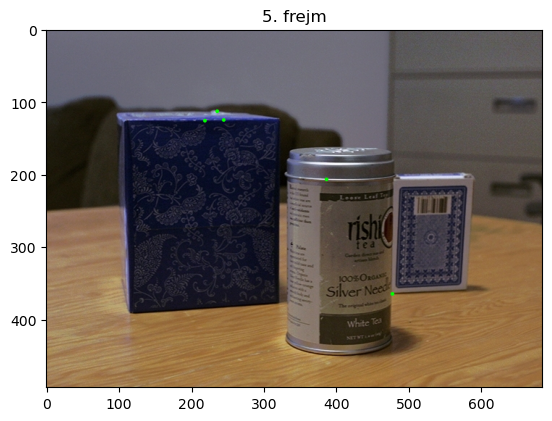

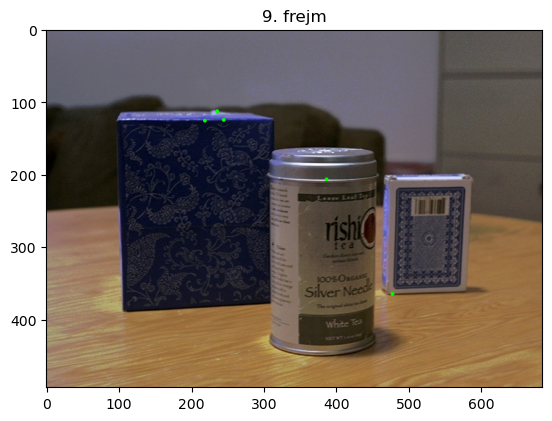

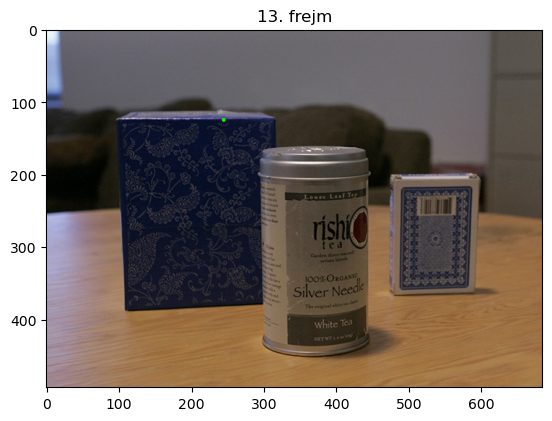

In [944]:
folder = 'Can'
frames = os.listdir(folder)
images = []
for frame in frames:
    images.append(cv.imread(os.path.join(folder,frame),cv.IMREAD_GRAYSCALE))
    images[-1] = np.float32((images[-1] - np.min(images[-1]))/(np.max(images[-1])-np.min(images[-1])))
    
keypoints = cv.goodFeaturesToTrack(images[0],200,0.01,10)
keypoints = np.int64(keypoints.reshape((len(keypoints),2)))

tmp = keypoints[:,0].copy()
keypoints[:,0] = keypoints[:,1]
keypoints[:,1] = tmp    


dst_folder = 'CanLK'

for k in range(len(images)-1):
    flowVectors, validPoints = lucasKanade(images[k],images[k+1],keypoints,5,1)

    out = cv.imread(os.path.join(folder,frames[k]))
    out = cv.cvtColor(out,cv.COLOR_BGR2RGB)

    for point in keypoints:
        j,i = point
        cv.circle(out,[i,j],1,(0,255,0),2)
    
    
    if k % 4 == 0:
        plt.imshow(out)
        plt.title(str(k+1) + ". frejm")
        plt.show()
    
    out = cv.cvtColor(out,cv.COLOR_RGB2BGR)
    cv.imwrite(os.path.join(dst_folder,frames[k]),out)
    
    keypoints[:,0] = np.int64(np.round(keypoints[:,0]+flowVectors[:,1]))
    keypoints[:,1] = np.int64(np.round(keypoints[:,1]+flowVectors[:,0]))
    keypoints = keypoints[validPoints,:]
    
    flowVectors = flowVectors[validPoints,:]

out = cv.imread(os.path.join(folder,frames[-1]))
out = cv.cvtColor(out,cv.COLOR_BGR2RGB)

for point in keypoints:
    j,i = point
    cv.circle(out,[i,j],1,(0,255,0),2)
    
plt.imshow(out)
plt.title("13. frejm")
plt.show()

out = cv.cvtColor(out,cv.COLOR_RGB2BGR)
flag = cv.imwrite(os.path.join(dst_folder,frames[-1]),out)

Vidimo da se vrlo brzo većina tačaka gubi odnosno prestaju da budu validne što je i očekivano jer Lukas-Kanade algoritam pretpostavlja male pomeraje između frejmova kako to ovde nije ispunjeno vremenom se tačke izgube. Slike svih frejmova su sačuvane u folder **CanLK**.

Kako bi se dobila bolja procena opitčkog toka korišćen je iterativni Lukas-Kanade algoritam. Ideja je da se pomeraj proceni iz više puta. Na ovaj način se veštački smanjuje pomeraj između frejmova odnosno nakon jedne iteracije se pomeraj umanji za estimirani pomeraj. Za inicijalnu procenu je uzeto da su vrednosti svih pomeraja 0. Za sledeću iteraciju se uzima vrednost pomeraja dobijena iz prethodne iteracije. Korišćen je prozor 9x9 i 7 iteracija po tački kao i prag greške 2.

In [945]:
def iterLucasKanade(img1,img2,keypoints,winSize,numIter,initFlow,errThr):
        
        N = len(keypoints)
        height, width = img1.shape
        
        flowVectors = initFlow
        
        Ix = cv.Sobel(img1,cv.CV_64F,1,0)
        Iy = cv.Sobel(img1,cv.CV_64F,0,1)

        for k,point in enumerate(keypoints):
            
            i,j = point
            
            for it in range(numIter):
                v,u = flowVectors[k]
                
                A = []
                b = []
                for m in range(i-winSize//2,i+winSize//2+1):
                    for n in range(j - winSize//2,j+winSize//2+1):
                        x = int(np.floor(m+u))
                        y = int(np.floor(n+v))
                        
                        # Bilinearna interpolacija
                        It = img2[x, y]*(1-(n+v-y))*(1-(m+u-x))+\
                             img2[x, y+1]*(1-(n+v-y))*(m+u-x)+\
                             img2[x+1, y]*(n+v-y)*(1-(m+u-x))+\
                             img2[x+1, y+1]*(n+v-y)*(m+u-x)
                        
                        It = It - img1[m,n]
                        A.append([Ix[m,n],Iy[m,n]])
                        b.append([-It])

                A = np.array(A)
                b = np.array(b)

                x = np.linalg.inv(np.transpose(A)@A)@np.transpose(A)@b

                flowVectors[k] += x.reshape(-1)
                
        validPoints = np.zeros(N,dtype='bool')

        for k, point in enumerate(keypoints):
            size = 3
            i,j = point

            new_i = i + flowVectors[k][1]
            new_j = j + flowVectors[k][0]

            if (0 <= new_i < height) and (0 <= new_j < width):

                win1 = img1[i-size//2:i+size//2+1,j-size//2:j+size//2+1]
                # Zbog problema zaokruzivanja koristimo bilinearnu interpolaciju
                win2 = img2[int(np.round(new_i))-1:int(np.round(new_i))+2,
                            int(np.round(new_j))-1:int(np.round(new_j))+2]*\
                            (1-(new_j-int(new_j)))*(1-(new_i-int(new_i)))+\
                        img2[int(np.round(new_i))-1+1:int(np.round(new_i))+2+1,
                             int(np.round(new_j))-1:int(np.round(new_j))+2]*\
                             (1-(new_j-int(new_j)))*(new_i-int(new_i))+\
                        img2[int(np.round(new_i))-1:int(np.round(new_i))+2,
                             int(np.round(new_j))-1+1:int(np.round(new_j))+2+1]*\
                             (new_j-int(new_j))*(1-(new_i-int(new_i)))+\
                        img2[int(np.round(new_i))-1+1:int(np.round(new_i))+2+1,
                             int(np.round(new_j))-1+1:int(np.round(new_j))+2+1]*\
                             (new_j-int(new_j))*(new_i-int(new_i))
                
                m1 = np.mean(win1)
                m2 = np.mean(win2)

                std1 = np.std(win1)
                std2 = np.std(win2)

                win1 = (win1 - m1)/std1
                win2 = (win2 - m2)/std2

                if np.mean((win1 - win2)**2) < errThr:

                    validPoints[k] = True

        
        return flowVectors, validPoints

Ispod se mogu videti vektori pomeraja između prve dve slike u sekvenci dobijeni iterativnim Lukas-Kanade algoritmom.

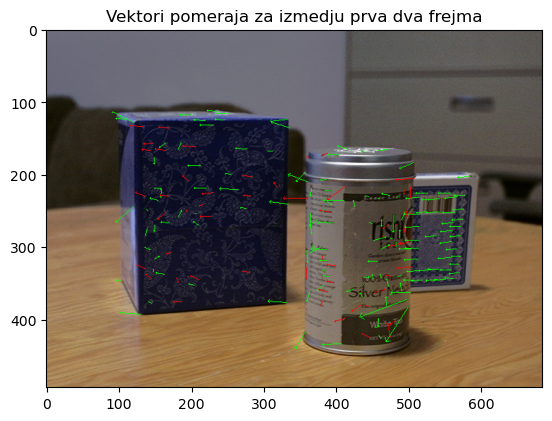

In [946]:
img_color = cv.imread("Can/frame01.jpg")
img_color = cv.cvtColor(img_color,cv.COLOR_BGR2RGB)

keypoints = cv.goodFeaturesToTrack(images[0],200,0.01,10)
keypoints = np.int64(keypoints.reshape((len(keypoints),2)))

tmp = keypoints[:,0].copy()
keypoints[:,0] = keypoints[:,1]
keypoints[:,1] = tmp

initFlow = np.zeros(keypoints.shape)

flowVectors, validPoints = iterLucasKanade(img,img2,keypoints,9,7,initFlow,2)

img_color = cv.imread("Can/frame01.jpg")
img_color = cv.cvtColor(img_color,cv.COLOR_BGR2RGB)

for i in range(len(keypoints)):
    l = 20*math.sqrt(flowVectors[i][0]**2 + flowVectors[i][1]**2)
    angle = math.atan2(flowVectors[i][0],flowVectors[i][1])
    
    if validPoints[i]:
        cv.arrowedLine(img_color,[keypoints[i][1],keypoints[i][0]],[int(keypoints[i][1] + l*math.sin(angle)),int(keypoints[i][0] + l*math.cos(angle))],(0,255,0),1)
    else:
        cv.arrowedLine(img_color,[keypoints[i][1],keypoints[i][0]],[int(keypoints[i][1] + l*math.sin(angle)),int(keypoints[i][0] + l*math.cos(angle))],(255,0,0),1)
plt.imshow(img_color)
plt.title("Vektori pomeraja za izmedju prva dva frejma")
plt.show()

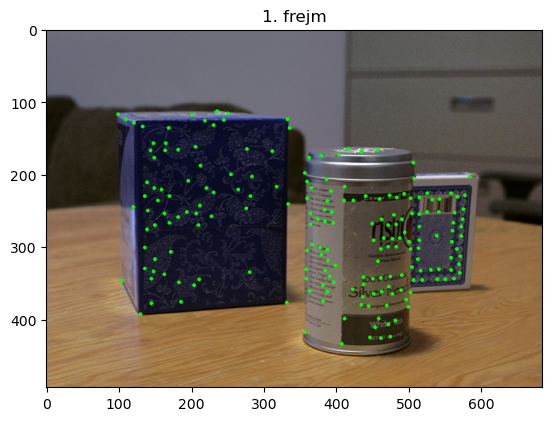

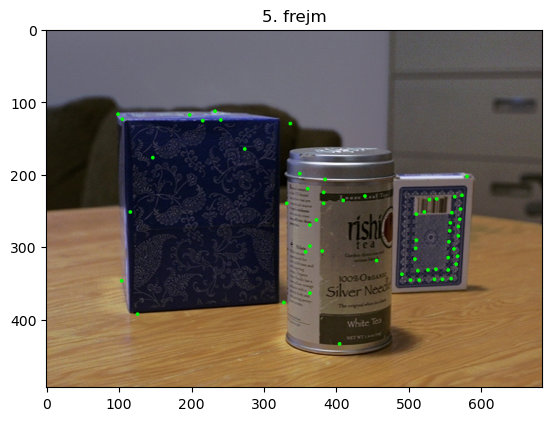

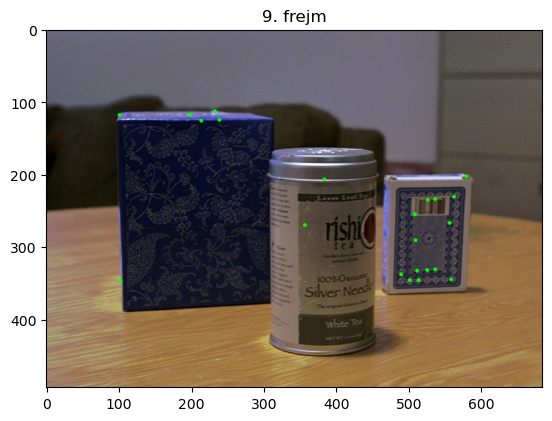

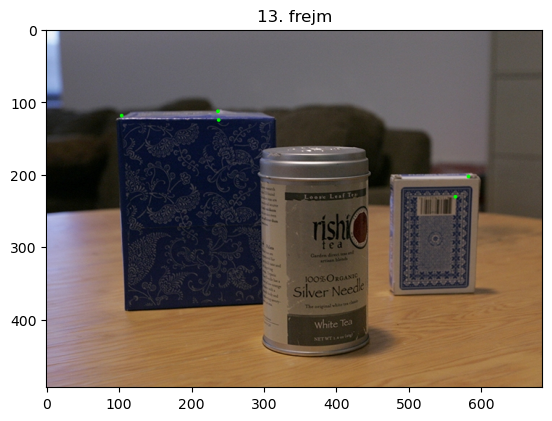

In [947]:
folder = 'Can'
frames = os.listdir(folder)
images = []
for frame in frames:
    images.append(cv.imread(os.path.join(folder,frame),cv.IMREAD_GRAYSCALE))
    images[-1] = np.float32((images[-1] - np.min(images[-1]))/(np.max(images[-1])-np.min(images[-1])))
    
keypoints = cv.goodFeaturesToTrack(images[0],200,0.01,10)
keypoints = np.int64(keypoints.reshape((len(keypoints),2)))

tmp = keypoints[:,0].copy()
keypoints[:,0] = keypoints[:,1]
keypoints[:,1] = tmp    


dst_folder = 'CanLKiter'

for k in range(len(images)-1):
    
    initFlow = np.zeros(keypoints.shape)
    flowVectors, validPoints = iterLucasKanade(images[k],images[k+1],keypoints,9,7,initFlow,2)

    out = cv.imread(os.path.join(folder,frames[k]))
    out = cv.cvtColor(out,cv.COLOR_BGR2RGB)

    for point in keypoints:
        j,i = point
        cv.circle(out,[i,j],1,(0,255,0),2)
    
    
    if k % 4 == 0:
        plt.imshow(out)
        plt.title(str(k+1) + ". frejm")
        plt.show()
    
    out = cv.cvtColor(out,cv.COLOR_RGB2BGR)
    cv.imwrite(os.path.join(dst_folder,frames[k]),out)
    
    keypoints[:,0] = np.int64(np.round(keypoints[:,0]+flowVectors[:,1]))
    keypoints[:,1] = np.int64(np.round(keypoints[:,1]+flowVectors[:,0]))
    keypoints = keypoints[validPoints,:]
    flowVectors = flowVectors[validPoints,:]

out = cv.imread(os.path.join(folder,frames[-1]))
out = cv.cvtColor(out,cv.COLOR_BGR2RGB)

for point in keypoints:
    j,i = point
    cv.circle(out,[i,j],1,(0,255,0),2)
    
plt.imshow(out)
plt.title("13. frejm")
plt.show()

out = cv.cvtColor(out,cv.COLOR_RGB2BGR)
flag = cv.imwrite(os.path.join(dst_folder,frames[-1]),out)

Vidimo da ostaje nešto više tačaka nego kod prve metode, ali i dalje se velika većina tačaka izgubi. Slike svih frejmova su sačuvane u folder **CanLKiter**. Kako je i dalje problem u veličini pomeraja ideja je to rešiti decimacijom odnosno kreiranjem Gausove piramide. Ispod je prikazan piramida koja se sastoji od originalne slike i 3 nivoa decimiranih slika. Faktor decimacije je 2.

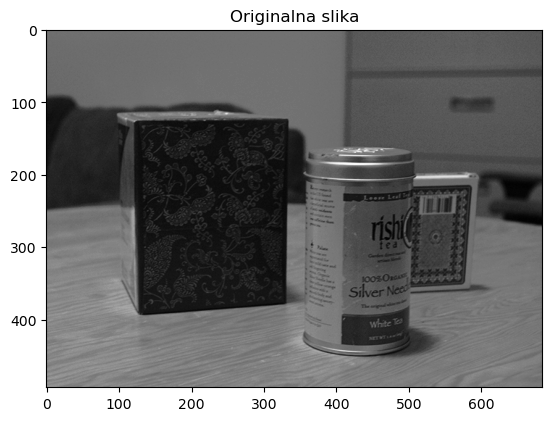

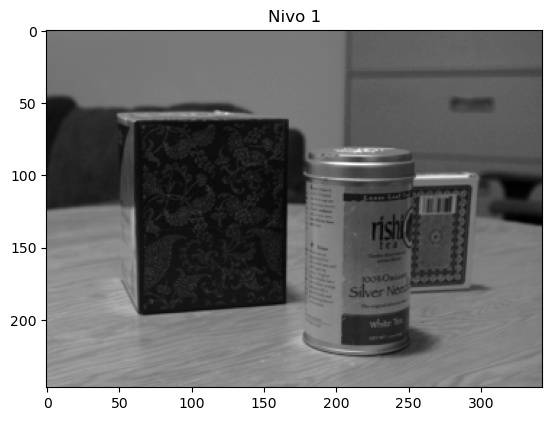

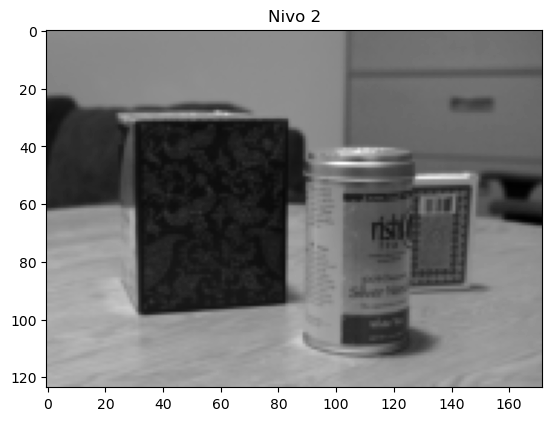

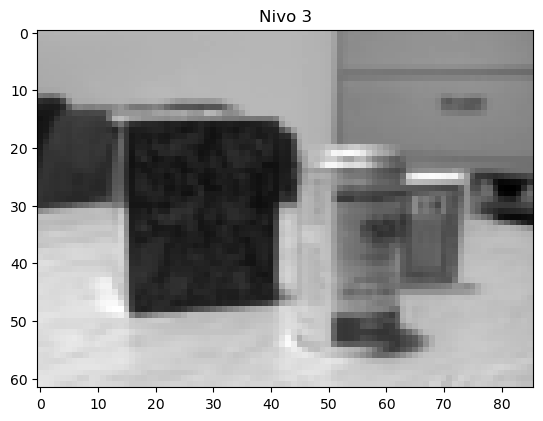

In [948]:
pyr = tuple(pyramid_gaussian(img,max_layer=3,downscale=2))

for k,p in enumerate(pyr):
    plt.imshow(p,cmap='gray')
    if k == 0:
        plt.title("Originalna slika")
    else:
        plt.title("Nivo " + str(k))
    plt.show()

Decimacijom slike se pomeraji na njoj efektivno smanjuju te bi Lukas-Kanade algoritam trebalo da daje preciznije rezultate. Ideja je slična kao i za iterativni Lukas-Kanade, koji se ovde i koristi. Počinjemo od najvišeg nivoa piramide tu se procenjuju pomeraji pomoću iterativnog Lukas-Kanade algoritma. Treba napomenuti da je neophodno skalirati pozicije obeležja tako da odgovaraju trenutnom nivou piramide. Procenjeni pomeraji se skaliraju faktorom decimacije i postaju inicijalna procena sa sledeći nivo. Ispod je data implementacija. Korišćen je prozor 9x9, 7 iteracija, 3 decimirana nivoa piramide, faktor decimacije 2 i prag greške 2.

In [949]:
def pyrLucasKanade(img1,img2,keypoints,winSize,numIter,levelNum,levelScale,errThr):
    
    pyr1 = tuple(pyramid_gaussian(img1,max_layer=levelNum,downscale=levelScale))
    pyr2 = tuple(pyramid_gaussian(img2,max_layer=levelNum,downscale=levelScale))
    
    flowVectors = np.zeros(keypoints.shape)
    
    for level in range(levelNum,-1,-1):
        
        scaled_keypoints = np.int64(keypoints/(levelScale**level))
        
        flowVectors, validPoints = iterLucasKanade(pyr1[level],pyr2[level],scaled_keypoints,winSize,numIter,levelScale*flowVectors,errThr)
    
    N = len(keypoints)
    height, width = img1.shape
    
    validPoints = np.zeros(N,dtype='bool')

    for k, point in enumerate(keypoints):
        size = 3
        i,j = point

        new_i = i + flowVectors[k][1]
        new_j = j + flowVectors[k][0]

        if (0 <= new_i < height) or (0 <= new_j < width):

            win1 = img1[i-size//2:i+size//2+1,j-size//2:j+size//2+1]
            win2 = img2[int(np.round(new_i))-1:int(np.round(new_i))+2,
                        int(np.round(new_j))-1:int(np.round(new_j))+2]*\
                        (1-(new_j-int(new_j)))*(1-(new_i-int(new_i)))+\
                    img2[int(np.round(new_i))-1+1:int(np.round(new_i))+2+1,
                         int(np.round(new_j))-1:int(np.round(new_j))+2]*\
                         (1-(new_j-int(new_j)))*(new_i-int(new_i))+\
                    img2[int(np.round(new_i))-1:int(np.round(new_i))+2,
                         int(np.round(new_j))-1+1:int(np.round(new_j))+2+1]*\
                         (new_j-int(new_j))*(1-(new_i-int(new_i)))+\
                    img2[int(np.round(new_i))-1+1:int(np.round(new_i))+2+1,
                         int(np.round(new_j))-1+1:int(np.round(new_j))+2+1]*\
                         (new_j-int(new_j))*(new_i-int(new_i))
            
            m1 = np.mean(win1)
            m2 = np.mean(win2)
            
            std1 = np.std(win1)
            std2 = np.std(win2)
            
            win1 = (win1 - m1)/std1
            win2 = (win2 - m2)/std2

            if np.mean((win1 - win2)**2) < errThr:
                validPoints[k] = True
        
    return flowVectors, validPoints

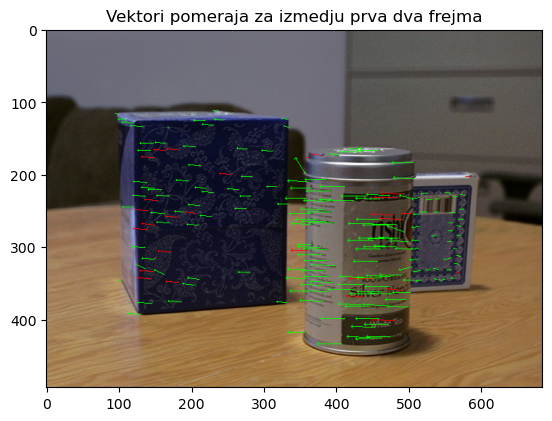

In [950]:
img_color = cv.imread("Can/frame01.jpg")
img_color = cv.cvtColor(img_color,cv.COLOR_BGR2RGB)

keypoints = cv.goodFeaturesToTrack(images[0],200,0.01,10)
keypoints = np.int64(keypoints.reshape((len(keypoints),2)))

tmp = keypoints[:,0].copy()
keypoints[:,0] = keypoints[:,1]
keypoints[:,1] = tmp

flowVectors, validPoints = pyrLucasKanade(images[0],images[1],keypoints,9,7,3,2,2)

img_color = cv.imread("Can/frame01.jpg")
img_color = cv.cvtColor(img_color,cv.COLOR_BGR2RGB)

for i in range(len(keypoints)):
    l = 5*math.sqrt(flowVectors[i][0]**2 + flowVectors[i][1]**2)
    angle = math.atan2(flowVectors[i][0],flowVectors[i][1])
    
    if validPoints[i]:
        cv.arrowedLine(img_color,[keypoints[i][1],keypoints[i][0]],[int(keypoints[i][1] + l*math.sin(angle)),int(keypoints[i][0] + l*math.cos(angle))],(0,255,0),1)
    else:
        cv.arrowedLine(img_color,[keypoints[i][1],keypoints[i][0]],[int(keypoints[i][1] + l*math.sin(angle)),int(keypoints[i][0] + l*math.cos(angle))],(255,0,0),1)
plt.imshow(img_color)
plt.title("Vektori pomeraja za izmedju prva dva frejma")
plt.show()

Vidimo da je velika većina tačaka ostala validna nakon prvog frejma, a za razilku od prethodnih slučajeva gde je bilo vektora koji pokazuju u nasumičnim pravcima sada čak i vektori koji odgovaraju odbačenim tačkama pokazuju u smislenom pravcu.

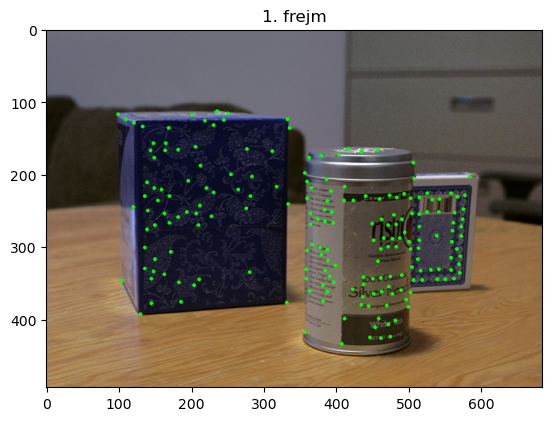

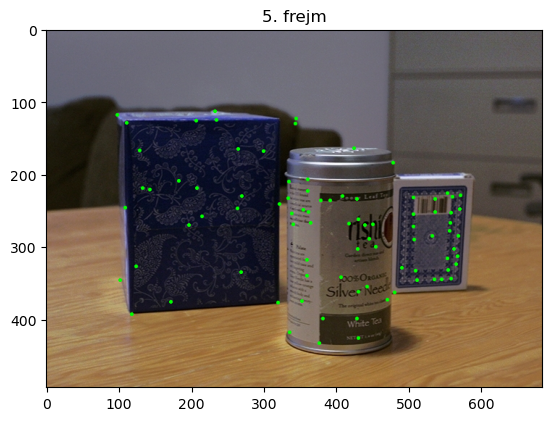

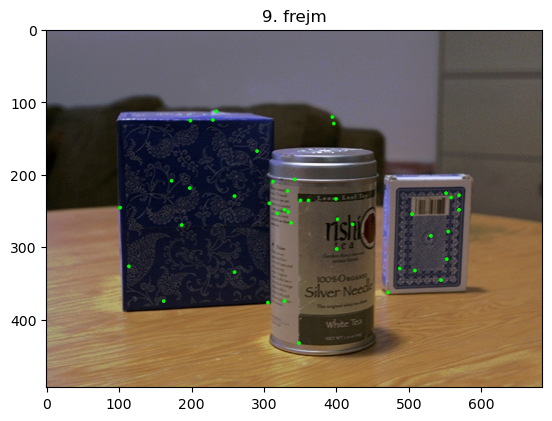

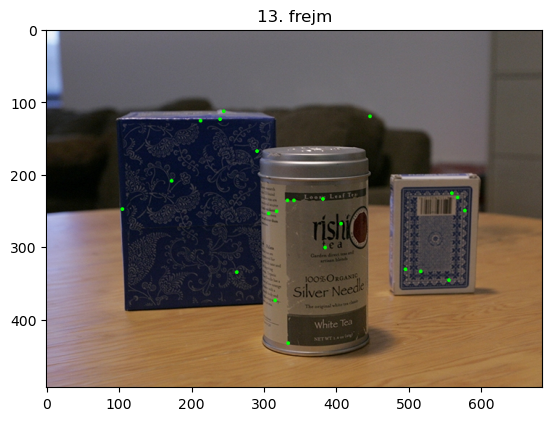

In [951]:
folder = 'Can'
frames = os.listdir(folder)
images = []
for frame in frames:
    images.append(cv.imread(os.path.join(folder,frame),cv.IMREAD_GRAYSCALE))
    images[-1] = np.float32((images[-1] - np.min(images[-1]))/(np.max(images[-1])-np.min(images[-1])))
    
keypoints = cv.goodFeaturesToTrack(images[0],200,0.1,10)
keypoints = np.int64(keypoints.reshape((len(keypoints),2)))

tmp = keypoints[:,0].copy()
keypoints[:,0] = keypoints[:,1]
keypoints[:,1] = tmp    


dst_folder = 'CanLKpyr'

for k in range(len(images)-1):
    
    flowVectors, validPoints = pyrLucasKanade(images[k],images[k+1],keypoints,9,7,3,2,1.5)

    out = cv.imread(os.path.join(folder,frames[k]))
    out = cv.cvtColor(out,cv.COLOR_BGR2RGB)

    for point in keypoints:
        j,i = point
        cv.circle(out,[i,j],1,(0,255,0),2)
    
    
    if k % 4 == 0:
        plt.imshow(out)
        plt.title(str(k+1) + ". frejm")
        plt.show()
    
    out = cv.cvtColor(out,cv.COLOR_RGB2BGR)
    cv.imwrite(os.path.join(dst_folder,frames[k]),out)
    
    keypoints[:,0] = np.int64(np.round(keypoints[:,0]+flowVectors[:,1]))
    keypoints[:,1] = np.int64(np.round(keypoints[:,1]+flowVectors[:,0]))
    keypoints = keypoints[validPoints,:]
    flowVectors = flowVectors[validPoints,:]

out = cv.imread(os.path.join(folder,frames[-1]))
out = cv.cvtColor(out,cv.COLOR_BGR2RGB)

for point in keypoints:
    j,i = point
    cv.circle(out,[i,j],1,(0,255,0),2)
    
plt.imshow(out)
plt.title("13. frejm")
plt.show()

out = cv.cvtColor(out,cv.COLOR_RGB2BGR)
flag = cv.imwrite(os.path.join(dst_folder,frames[-1]),out)

Sada se vidi da je dosta tačaka ostalo validno do kraja te ćemo ovaj algoritam koristiti u poslednjo tački gde je potrebno praćenje čovekovog lica. Slike svih frejmova su sačuvane u folder **CanLKpyr**.

Sada ćemo pokušati primenom algoritma iz prethodne tačke da pratimo lice čoveka. Prvi korak jeste da ručno napravimo pravougaonik oko lica što je prikazano dole zajedno sa detektovanim obeležijima na njemu. Minimalan kvalitet obeležja je 0.01, a minimalno rastojanje je 2.

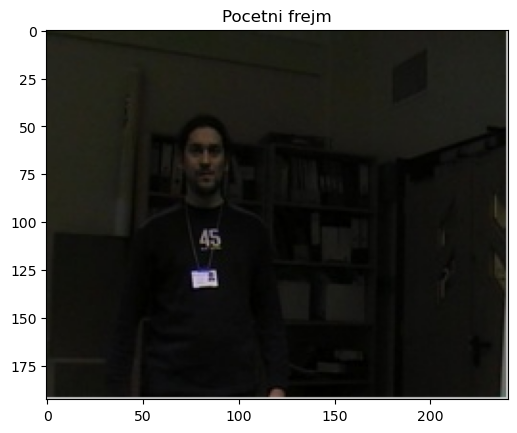

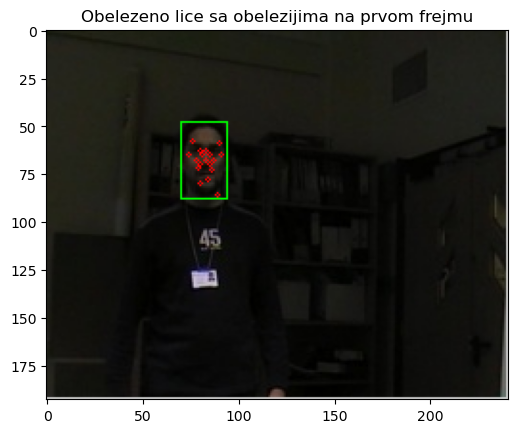

In [952]:
folder = "Man"
files = os.listdir(folder)
frames = []
frames_gray = []
for file in files:
    img = cv.imread(os.path.join(folder,file))
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    frames.append(img)
    
for file in files:
    img = cv.imread(os.path.join(folder,file), cv.IMREAD_GRAYSCALE)
    frames_gray.append(img)

face_height = 40
face_width = 24
face_x = 48 
face_y = 70 

plt.imshow(frames[0])
plt.title("Pocetni frejm")
plt.show()

keypoints = cv.goodFeaturesToTrack(cv.cvtColor(frames[0],cv.COLOR_RGB2GRAY),10000,0.01,2)
keypoints = np.int64(keypoints.reshape((len(keypoints),2)))

tmp = keypoints[:,0].copy()
keypoints[:,0] = keypoints[:,1]
keypoints[:,1] = tmp

keypoints_face = []
for point in keypoints:
    i,j = point
    if (i > face_x) and (i < face_x + face_height) and (j > face_y) and (j < face_y + face_width):
            keypoints_face.append(point)

keypoints_face = np.array(keypoints_face)
            
out = frames[0].copy()

for point in keypoints_face:
    j,i = point
    cv.circle(out,[i,j],1,(255,0,0),1)

cv.rectangle(out,(face_y,face_x),(face_y+face_width,face_x+face_height),(0,255,0),1)

plt.imshow(out)
plt.title("Obelezeno lice sa obelezijima na prvom frejmu")
plt.show()


Algoritmom se prate tačke na licu pomoću piramidalnog Lukas-Kanade algoritma. Pomera se gornja leva tačka pravougaonika dok njegova dužina i širina ostaju nepromenjene. I dalje odbacujemo nevalidne tačke, ali sada odbacujemo i tačke koje se nalaze van granica pravougaonika. Kako na ovaj način broj tačaka brzo opada neophodno je iznova ih detektovati na svakih 20 frejma. Takođe, kako bi se dobili bolji rezultati greška zaokruživanja je pamćena i prenošena na sledeći frejm. Korišćen je 7x7 prozor, 15 iteracija, 3 decimirana nivoa piramide, faktor decimacije 2 i prag greške 1.25. Rešenja su sačuvana kao video sekvence *man_track.mp4* (sekvenca sa pravougaonikom) i *man_track_key.mp4* (sekvenca sa pravougaonikom i ucrtanim obeležijima). Na snimcima se može primetiti da se lice uspešno prati iako nije idealno jer pravougaonik se nalazi nešto niže u odnosu na lice nego što je to bio slučaj na prvom frejmu.

In [953]:
face_height = 40
face_width = 24
face_x = 48
face_y = 70 
shift = np.zeros(2)
for k in range(len(frames_gray)-1):
    
    if k % 20 == 0:
        keypoints = cv.goodFeaturesToTrack(cv.cvtColor(frames[k],cv.COLOR_RGB2GRAY),10000,0.01,2)
        keypoints = np.int64(keypoints.reshape((len(keypoints),2)))

        tmp = keypoints[:,0].copy()
        keypoints[:,0] = keypoints[:,1]
        keypoints[:,1] = tmp

        keypoints_face = []
        
        for point in keypoints:
            i,j = point
            if  (i > face_x) and (i < face_x + face_height) and (j > face_y) and (j < face_y + face_width):
                    keypoints_face.append(point)
            
        keypoints_face = np.array(keypoints_face)
    
    flowVectors, validPoints = pyrLucasKanade(frames_gray[k],frames_gray[k+1],keypoints_face,7,15,3,2,1.25)
    
    keypoints_face[:,0] = np.int64(np.round(keypoints_face[:,0]+flowVectors[:,1]))
    keypoints_face[:,1] = np.int64(np.round(keypoints_face[:,1]+flowVectors[:,0]))
    keypoints_face = keypoints_face[validPoints,:]
    flowVectors = flowVectors[validPoints,:]

    shift += [np.mean(flowVectors[:,0]), np.mean(flowVectors[:,1])]

    face_x += int(np.round(shift[1]))
    face_y += int(np.round(shift[0]))
    
    shift -= np.int64(np.round(shift))

    out = frames[k+1].copy()
    out = cv.cvtColor(out,cv.COLOR_RGB2BGR)
    cv.rectangle(out,(face_y,face_x),(face_y+face_width,face_x+face_height),(0,255,0),1)

    in_rect = np.zeros(len(keypoints_face),dtype='bool')
    for l,point in enumerate(keypoints_face):
        i,j = point

        if (i > face_x) and (i < face_x + face_height) and (j > face_y) and (j < face_y + face_width):
                   in_rect[l] = True

    keypoints_face = keypoints_face[in_rect,:]
    flowVectors = flowVectors[in_rect,:]

#     for point in keypoints_face:
#         j,i = point
#         cv.circle(out,[i,j],1,(0,0,255),1)


    cv.imwrite(os.path.join("LKMan",files[k]),out)

In [954]:
def create_video_from_images(image_folder, video_name,fps=30):
    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    frame = cv.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv.VideoWriter(video_name, cv.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv.imread(os.path.join(image_folder, image)))

    cv.destroyAllWindows()
    video.release()

In [955]:
create_video_from_images('Man','man.mp4')


In [956]:
create_video_from_images('LKMan','man_track.mp4')